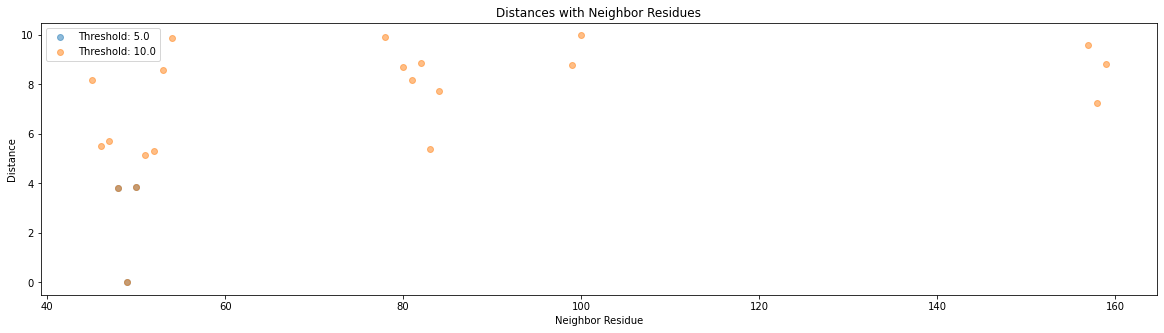

In [4]:
from Bio import PDB
from Bio.PDB import NeighborSearch
from scipy.spatial.distance import euclidean
import pandas as pd
import matplotlib.pyplot as plt

def calculate_distances_with_neighbor_residues_CA(structure, target_residue, threshold_distance):
    ns = NeighborSearch(list(structure.get_atoms()))
    distances_with_neighbor_residues_CA = []

    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[1] == target_residue:
                    try:
                        target_ca_atom = residue['CA']
                    except KeyError:
                        print(f"CA atom not found in target residue {residue.id}")
                        continue

                    for neighbor_atom in ns.search(target_ca_atom.get_coord(), threshold_distance):
                        if neighbor_atom.name == 'CA':
                            distance = euclidean(target_ca_atom.get_coord(), neighbor_atom.get_coord())
                            neighbor_residue_number = neighbor_atom.parent.id[1]
                            distances_with_neighbor_residues_CA.append((chain.id, residue.id, neighbor_residue_number, distance))

    return distances_with_neighbor_residues_CA

if __name__ == "__main__":
    pdb_filename = "HumanCys.pdb"  # Replace with the path to your PDB file
    target_residue_number = 49  # Replace with the target residue number
    distance_thresholds = [5.0, 10.0]  # Adjust the distance thresholds as needed

    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_filename)

    # Plotting with different colors for each distance threshold
    for i, distance_threshold in enumerate(distance_thresholds):
        distances_with_neighbor_residues_CA = calculate_distances_with_neighbor_residues_CA(structure, target_residue_number, distance_threshold)

        with open(f"distances_{distance_threshold}.tsv", "w") as output_file:
            output_file.write("Chain\tResidue\tNeighbor_Residue\tDistance\n")
            for chain_id, residue_id, neighbor_residue_number, distance in distances_with_neighbor_residues_CA:
                output_file.write(f"{chain_id}\t{residue_id[1]}\t{neighbor_residue_number}\t{distance:.2f}\n")

        # Read data from TSV file
        file_path = f"distances_{distance_threshold}.tsv"
        data = pd.read_csv(file_path, sep='\t')

        # Extract data for plotting
        neighbor_residues = data['Neighbor_Residue']
        distances = data['Distance']

        # Assign different colors based on distance threshold
        colors = f'C{i}'  # Use a different color for each threshold (C0, C1, etc.)

        #increasing the plot size
        plt.rcParams['figure.figsize'] = [20, 5]

        # Plot the data with 'Neighbor_Residue' on the x-axis and 'Distance' on the y-axis
        plt.scatter(neighbor_residues, distances, color=colors, alpha=0.5, label=f'Threshold: {distance_threshold}')

    plt.title('Distances with Neighbor Residues')
    plt.xlabel('Neighbor Residue')
    plt.ylabel('Distance')
    plt.legend()
    plt.show()